In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import seaborn as sns
%matplotlib inline
sns.set()  

In [2]:
def rmse_loss(ratings_test, ratings_predict):
    return round(np.sqrt(metrics.mean_squared_error(ratings_test, ratings_predict)), 4)

In [3]:
MAXN, MAXM, MAXK = 1005, 2005, 20
U = np.empty((MAXN, MAXK), dtype="float32")
V = np.empty((MAXM, MAXK), dtype="float32")

In [4]:
with open("model_al0.100_et0.010.out", "r") as f:
    for i, line in enumerate(f):
        if i < MAXN:
            U[i] = np.array(line.split())
        else:
            V[i - MAXN] = np.array(line.split())
            
R = U.dot(V.T)

In [5]:
records_train = np.loadtxt("../data/ML100K/ML100K_copy1_train.txt", dtype=np.int32)
records_test = np.loadtxt("../data/ML100K/ML100K_copy1_test.txt", dtype=np.int32)

records = np.r_[records_train, records_test]

ratings_test = records_test[:, 2]
ratings_train = records_train[:, 2]

ratings_predict = U.dot(V.T)[records_test[:, 0], records_test[:, 1]]
ratings_predict_train = U.dot(V.T)[records_train[:, 0], records_train[:, 1]]

In [6]:
# print(rmse_loss(np.clip(U.dot(V.T)[records_test[:, 0], records_test[:, 1]], 1, 5), ratings_test))
print(rmse_loss(ratings_predict, ratings_test))

0.9408


In [7]:
print(rmse_loss(U.dot(V.T)[records_train[:, 0], records_train[:, 1]], records_train[:, 2]))

0.7723


In [8]:
diff = np.abs(ratings_test - ratings_predict)

In [9]:
diff.mean(), diff.std(), diff.var(), diff.max(), diff.min()

(0.7408770218041493,
 0.5797916546993358,
 0.3361583628589938,
 4.968394249677658,
 1.1444091796875e-05)

In [10]:
diff_train = np.abs(ratings_train - ratings_predict_train)
diff_train.mean(), diff_train.std(), diff_train.var(), diff_train.max(), diff_train.min()

(0.6181621153155963,
 0.46290593839691196,
 0.21428190780312567,
 3.37339448928833,
 7.62939453125e-06)

# Calculate activeness

In [11]:
def get_user_active(records):
    n = np.unique(records[:, 0]).max()
    return np.array([(records_train[:, 0] == uid).sum() for uid in range(0, n + 1)], dtype='float')

def get_item_active(records):
    m = np.unique(records[:, 1]).max()
    return np.array([(records_train[:, 1] == iid).sum() for iid in range(0, m + 1)], dtype='float')

In [12]:
user_active = get_user_active(np.r_[records_train, records_test])
item_active = get_item_active(np.r_[records_train, records_test])

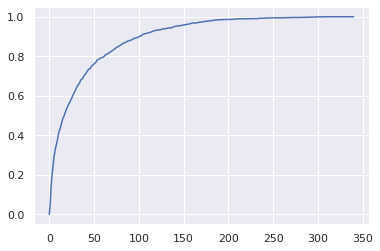

In [13]:
plt.plot(np.arange(int(item_active.max())), [(item_active < t).sum() / len(item_active) for t in range(int(item_active.max()))])

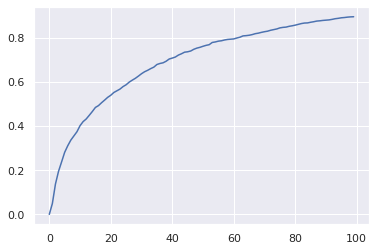

In [14]:
item_activeness = item_active.copy()
item_activeness[item_activeness > 100] = 100
plt.plot(np.arange(int(item_activeness.max())), [(item_activeness < t).sum() / len(item_activeness) for t in range(int(item_activeness.max()))])

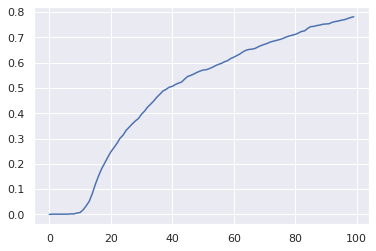

In [15]:
user_activeness = user_active.copy()
user_activeness[user_activeness > 100] = 100
plt.plot(np.arange(int(user_activeness.max())), [(user_activeness < t).sum() / len(user_activeness) for t in range(int(user_activeness.max()))])

<AxesSubplot:ylabel='Density'>

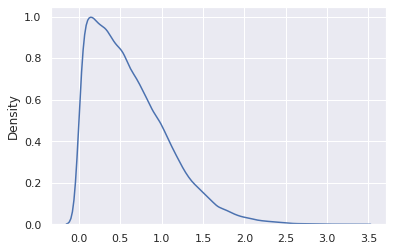

In [16]:
sns.kdeplot(diff_train)

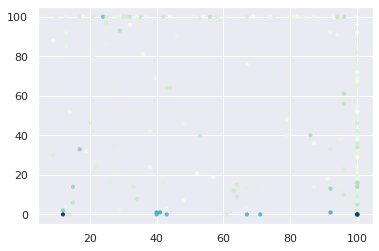

In [17]:
records_outlier_test = [record for record in records_test if abs(R[record[0], record[1]] - record[2]) > 2.5]


plt.scatter([user_activeness[record[0]] for record in records_outlier_test],
            [item_activeness[record[1]] for record in records_outlier_test],
            c=[abs(R[record[0], record[1]] - record[2]) for record in records_outlier_test],
            cmap='GnBu', s=10)